# Data to Model Relevance
## How (dis)similar are train and test data?

There may be cases, when even after selecting the best model (with cross-validation), that performs well on training data, this model fails to match up to the same performance for the test data.

The reason for this may be not overfitting, but some inherent patterns in test data that model is not capturing.

These new parterns result in a _dataset shift_ when the training and test distributions are different.

Types of dataset shift:

- Covariate shift
- Prior probability shift
- Concept shift
- Internal covariate shift (an important subtype of covariate shift)

## Covariate Shift

Target variable in train and test set have the same functional dependency on input variables, but variables have different distribution.

$\mathbf P_{train}(y|x) = P_{test}(y|x)$<br>
$\mathbf P_{train}(x) \neq P_{test}(x) $<br>

The relevance of test data to a trained model can be calculated by checking if predictor variables have a different distribution in train and test data.

**Main idea:** If there exists a covariate shift, then upon mixing train and test we’ll be able to classify the origin of each data point (whether it is from test or train) with good accuracy.

Then a relevance weight $w_{train}$ of test sample $x_{test}$ in the train set is the probability of this sample to be in the train set.

$\mathbf w_{train}(x_{test}) = P_{train}(x_{test})$<br>


To evaluate this idea, train and test sets are generated. The test is has a covariate shift. The train set is further splited into two sets with the same distribution: validation and train sets. 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score

In [2]:
all_train_df_name = 'm2d_train_all.csv'
train_df_name = 'm2d_train.csv'
test_df_name = 'm2d_test.csv'
valid_df_name = 'm2d_valid.csv'

In [3]:
def regressor(reg, x_train, y_train, x_valid, y_valid, x_test, y_test):
    """Train, predict and return metrics
       Input:
           reg - regression model instnace
    """
   
    reg.fit(x_train, y_train)
    pred_valid = reg.predict(x_valid)
    pred_test = reg.predict(x_test)
    reg_score = reg.score(x_train, y_train)
    mse_valid = mean_squared_error(y_valid, pred_valid)
    mse_test = mean_squared_error(y_test, pred_test)
    r2_valid = r2_score(y_valid, pred_valid)
    r2_test = r2_score(y_test, pred_test)
    return reg_score, pred_valid, pred_test, mse_valid, mse_test, r2_valid, r2_test

In [4]:
def plot(x_train, y_train, x_test, y_test, x_valid, y_valid, pred_valid, pred_test):
    # Scatter plot of target 'y' from 'X'
    _=plt.plot(x_train, y_train, marker='.', 
               linestyle = 'none', label='train', color='blue')
    _=plt.plot(x_valid, y_valid, marker='.', 
               linestyle = 'none', label='valid', color='orange')
    _=plt.plot(x_test, y_test, marker='.', 
               linestyle = 'none', label='test', color='red')
    _=plt.xlabel("X")
    _=plt.ylabel("Y")

    # Plot predictions 
    _=plt.plot(x_valid, pred_valid, marker='.', color='green', linestyle = 'none', label='pred_val')
    _=plt.plot(x_test, pred_test, marker='.', color='black', linestyle = 'none', label='pred_test')
    _=plt.legend()
    _=plt.show()
    _=plt.close()

In [5]:
# make some data which has a clear covariate shift
n_samples_X = 5000
n_samples_TEST = 500

In [6]:
x = 11*np.random.random(n_samples_X)- 6.0
y = x**2 + 10*np.random.random(n_samples_X) - 5
all_train_df = pd.DataFrame({'x':x, 'y':y})

x = 2*np.random.random(n_samples_TEST) - 7.5
y = x**2 + 10*np.random.random(n_samples_TEST) - 5
test_df = pd.DataFrame({'x':x, 'y':y})

train_df, valid_df = train_test_split(all_train_df, test_size=0.1, random_state=0)
print("Train {} Test {} Valid {} ".format(len(train_df), len(test_df), len(valid_df)))


Train 4500 Test 500 Valid 500 


In [7]:
all_train_df.to_csv(all_train_df_name, index=False)
test_df.to_csv(test_df_name, index=False)
valid_df.to_csv(valid_df_name, index=False)
train_df.to_csv(train_df_name, index=False)

In [8]:
x_train = np.array(train_df['x']).reshape(-1,1)
y_train = np.array(train_df['y']).reshape(-1,1)
x_valid = np.array(valid_df['x']).reshape(-1,1)
y_valid = np.array(valid_df['y']).reshape(-1,1)
x_test = np.array(test_df['x']).reshape(-1,1)
y_test = np.array(test_df['y']).reshape(-1,1)

<b>Logistic Regression. Validation and Test set Predictions</b>

In [9]:
reg = LinearRegression()
reg_score, pred_valid, pred_test, mse_valid, mse_test, r2_valid, r2_test = regressor(reg, x_train, y_train, x_valid, y_valid, 
                                       x_test, y_test)
print("reg_score {} mse_valid {} mse_test {} r2_valid {} r2_test {}".format(reg_score, mse_valid, mse_test, r2_valid, r2_test))

reg_score 0.10974278268536686 mse_valid 84.10973956564185 mse_test 695.751008643663 r2_valid 0.05686429683669403 r2_test -10.281762547193827


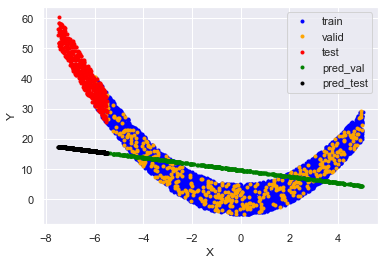

In [10]:
plot(x_train, y_train, x_test, y_test, x_valid, y_valid, pred_valid, pred_test)

<b>Random Forest. Validation and Test set Predictions</b>

In [11]:
reg = RandomForestRegressor(max_depth=2)
reg_score, pred_valid, pred_test, mse_valid, mse_test, r2_valid, r2_test = regressor(reg, 
                                    x_train, y_train, x_valid, y_valid, x_test, y_test)
print("reg_score {} mse_valid {} mse_test {} r2_valid {} r2_test {}".format(reg_score, mse_valid, mse_test, r2_valid, r2_test))

reg_score 0.786495297776707 mse_valid 23.51436208419517 mse_test 199.71099571285333 r2_valid 0.7363297694982613 r2_test -2.238359705849888


/var/folders/t9/p37t8t395zv52svjcyqg0sdm0000gn/T/ipykernel_3572/3803402861.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(x_train, y_train)


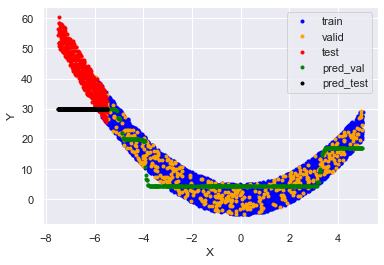

In [12]:
plot(x_train, y_train, x_test, y_test, x_valid, y_valid, pred_valid, pred_test)

<b>Calculate test sample relevance weights</b>
<ul>
<li>Drop target variable from train
<li>Add categorical variable 'is_train' to train and test sets and combine them
<li>Use StratifiedKFold to train classifier and predict probabilities of all samples to be from the train and test sets.
<li>Calculate test sample relevance weights as probability of test sample to be in the train set. 
 </ul>

In [13]:
def test_weights(test, train, target):
    """Calculate test weights
    """
    # Adding a column to identify whether a row comes from train or not
    test.loc[:,('is_train')] = 0
    train.loc[:,('is_train')] = 1 
    
    # Combining test and train data
    df_combine = pd.concat([train, test], axis=0, ignore_index=True)
    
    # Dropping ‘target’ column as it is not present in the test
    df_combine = df_combine.drop(target, axis =1)
    
    # Labels
    y = df_combine['is_train'].values 
    
    # Covariates or our independent variables
    x = df_combine.drop('is_train', axis=1).values 
    tst, trn = test.values, train.values
    
    # Predict the labels for each row in the combined dataset. 
    m = RandomForestClassifier(n_jobs=-1, max_depth=5, min_samples_leaf = 5)
    predictions = np.zeros((y.shape[0],2)) #creating an empty prediction array
    
    # Stratified fold to ensure that percentage for each class is preserved 
    # and we cover the whole data once. 
    # For each row the classifier will calculate the probability of it belonging to train.
    skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=100)
    for fold, (train_idx, test_idx) in enumerate(skf.split(x, y)):
        X_train, X_test = x[train_idx], x[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
 
        m.fit(X_train, y_train)
        predictions[test_idx] = m.predict_proba(X_test) #calculating the probability
        
    # High AUC (greater than 0.8) implies strong covariate shift between train and test.
    auc =  AUC(y, predictions[:, 1])
    
    predictions_test = predictions[len(trn):]
    #Test relevance weights equal to the probability of test sample to be in train set
    test_relevance_weights = predictions_test[:,1]
    
    return auc, test_relevance_weights, predictions


In [14]:
auc, test_relevance_weights, probs = test_weights(test_df, train_df, 'y')

In [15]:
print(auc)

0.9935955555555556


<ul>
<li>For test AUC > 0.9 which indicates that train and test sets are well separated.

<li>Train and test sets and have different distributions, as expected for the test with covariate shift. 

<li>Distribution of test to model relevance has most weights less then 0.1
</ul>

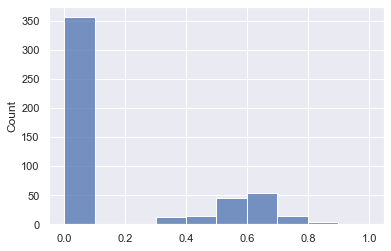

In [16]:
_=sns.histplot(test_relevance_weights, kde=False)

In [17]:
auc, test_relevance_weights, predictions = test_weights(valid_df, train_df, 'y')

In [18]:
print(auc)

0.5210735555555556


<ul>
<li>For validation data AUC is around 0.5 which indicates that train and validation sets have the similar distribution. <li>Distribution of test to model relevance has most weights around 0.9. 
<li>Validation data was randomly choosen from the train set and has no covariate shift.
</ul>

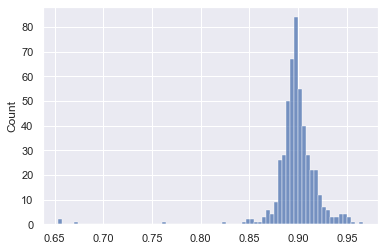

In [19]:
_=sns.histplot(test_relevance_weights, kde=False)

In [20]:
all_train_df = pd.read_csv(all_train_df_name, index_col=False)
all_train_df.info()
all_train_df.head()

df = pd.read_csv(valid_df_name, index_col=False)
df.info()
df.head()

test_df = pd.read_csv(test_df_name, index_col=False)
test_df.info()
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       5000 non-null   float64
 1   y       5000 non-null   float64
dtypes: float64(2)
memory usage: 78.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       500 non-null    float64
 1   y       500 non-null    float64
dtypes: float64(2)
memory usage: 7.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       500 non-null    float64
 1   y       500 non-null    float64
dtypes: float64(2)
memory usage: 7.9 KB


,x,y
0,-6.323776,41.636744
1,-6.546825,38.493420
2,-6.582256,40.857803
3,-6.600170,43.830024
4,-6.338276,43.097777
